### Birth-death process:
$ \dfrac{dx_i}{dt} = -B x_i^b + R \sum_j A_{ij} x_j^a$
* b=3, a=2
* b=2, a=1
* b=0.5, a=0.2

### Mutualistic
$ \dfrac{dx_i}{dt} = B x_i(1-x_i^b) + R \sum_j A_{ij} x_i \dfrac{x_j^a}{1+x_j^a} $
* b=2, a=1
* b=1, a=2

### Generalized Lotka-Volterra
$ \dfrac{dx_i}{dt} = -B x_i + R \sum_j A_{ij} x_i x_j $

In [1]:
# Provare birth death
# a=1,b=1
# a=2,b=1
# a=1,b=2
# a=2,b=2
# a=1,b=0.5
# a=0.5,b=1

In [67]:
import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
from numpy import genfromtxt
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 3

import utils.CommonFunctions as cf
import utils.plotter as plotter

import importlib
importlib.reload(cf)
importlib.reload(plotter)

<module 'utils.plotter' from '/home/barzon/Network_geometry/utils/plotter.py'>

# Networks
from https://www.web-of-life.es
* food webs (FW011, FW015)
* pollinators (M_PL_010, M_PL_022)

from https://networks.skewed.de/?search=
* fresh_webs — Freshwater stream webs
* plant_pol_kato — Kato plant-pollinator web (BUT too big)

In [82]:
# Read network
fname = 'data/AkatoreA/'

nodes = genfromtxt(fname+'nodes.csv', delimiter=',').astype(int)
edges = genfromtxt(fname+'edges.csv', delimiter=',').astype(int)

nodes = nodes[:,0]

N = len(nodes)
N_links = len(edges)

# Create adjacency matrix
A = np.zeros((N,N))

for edge in edges:
    A[edge[0],edge[1]] = 1

# Symmetrize A
A = A + A.T

G = nx.from_numpy_array(A)
G.remove_nodes_from(list(nx.isolates(G)))
print(nx.is_connected(G))
A = nx.to_numpy_array(G)
G = nx.from_numpy_array(A)

True


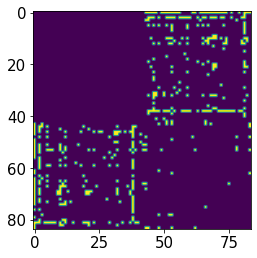

In [83]:
plt.imshow(A)
plt.show()

In [78]:
# Read network
fname = 'data/M_PL_010.csv'

data = pd.read_csv(fname, index_col=0)

In [79]:
data

,Aedes impiger,Aedes nigripes,Aphidius sp1 M_PL_010,Bombus sp1 M_PL_010,Brachypogon sp1 M_PL_010,Bradysia sp1 M_PL_010,Chironomus sp1 M_PL_010,Clossiana chariclea,Colias hecla,Cricotopus sp1 M_PL_010,...,Sympistis zetterstedti,Syngrapha parilis,Unidentified sp1 M_PL_010,Unidentified sp2 M_PL_010,Unidentified sp3 M_PL_010,Unidentified sp4 M_PL_010,Unidentified sp5 M_PL_010,Unidentified sp6 M_PL_010,Unidentified sp7 M_PL_010,Zaphne frontata
Arenaria pseudofrigida,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Armeria scabra,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
Arnica angustifolia,0,0,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Cassiope tetragona,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
Cerastium arcticum,1,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
Cochlearia groenlandica,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Draba arctica,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Draba lactea,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dryas octopetala,1,1,0,0,0,1,0,1,1,0,...,1,0,0,0,1,1,0,0,0,0
Epilobium latifolium,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [80]:
A = data.to_numpy()

In [81]:
G = nx.from_numpy_array(A)

NetworkXError: Adjacency matrix not square: nx,ny=(31, 76)

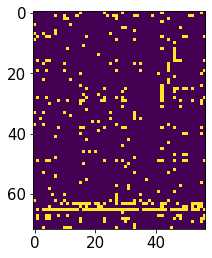

In [73]:
plt.imshow(A)

In [6]:
def Simu(G, infoG, dynamics_list = cf.dynamics_list, norm=True, t_scale = 1, t_max = 1):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    #num_time_points = 50 # small to decrease computational load
    times = np.linspace(0, num_nodes, num = num_nodes+1) #time to find the steady state    
    times_perturbation = np.linspace(0, int(num_nodes * t_max), num = int((num_nodes+1)*t_scale)) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    dist_t = []
    avg_dist_t = []
    eigvals = []
    
    for dynamics in dynamics_list:
        
        if dynamics == 'Diffusion':
            ### DIFFUSION
            print('[*] DIFFUSION DISTANCE')
            print('Evaluating diffusion distance...')
            tmp_d = cf.Laplacian(nx.to_numpy_array(G), times_perturbation, return_snapshot=True, norm=True)
        
        else:
            ### JACOBIAN
            print('[*] JACOBIAN DISTANCE - '+str(dynamics))
        
            #Integration to get the steady state
            print('Integration up to steady state...')
            initial_state = np.random.random(len(G.nodes()))
            SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
            SteadyState_ref = SteadyState_ref[-1]

            # analytical expression of Jacobian
            print('Evaluating jacobian distance...')
            tmp_d = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True, norm=norm)
        
        dist_t.append(tmp_d[0])
        avg_dist_t.append(tmp_d[1])
        eigvals.append(tmp_d[2])
        
    return dist_t, avg_dist_t, eigvals, times_perturbation

In [40]:
def Simu_params(G, infoG, dynamics, params, t_scale = 1, t_max = 1):
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    #num_time_points = 50 # small to decrease computational load
    times = np.linspace(0, num_nodes, num = num_nodes+1)
    times_perturbation = np.linspace(0, int(num_nodes * t_max), num = int((num_nodes+1)*t_scale)) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    dist_t = []
    avg_dist_t = []
    eigvals = []
    
    for param in params:
        print('[*] JACOBIAN DISTANCE - '+dynamics+'- PARAMS: '+str(param))
        
        #Integration to get the steady state
        print('Integration up to steady state...')
        initial_state = np.random.random(len(G.nodes()))
        SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1, args = param)
        SteadyState_ref = SteadyState_ref[-1]

        # analytical expression of Jacobian
        print('Evaluating jacobian distance...')
        tmp_d = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True, norm=True, args = param)
        
        dist_t.append(tmp_d[0])
        avg_dist_t.append(tmp_d[1])
        eigvals.append(tmp_d[2])
    
    return dist_t, avg_dist_t, eigvals, times_perturbation

# Diffusion distance

In [7]:
diffusion = Simu(G, [], dynamics_list = ['Diffusion'])

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/85 [00:00<?, ?it/s]

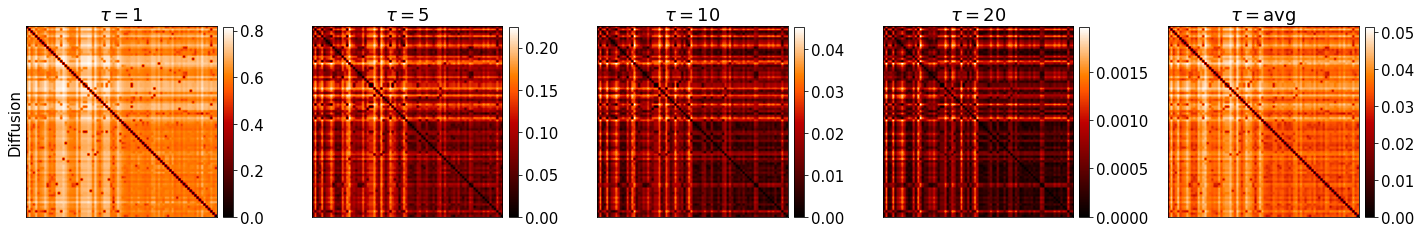

In [9]:
plotter.plot_dist_matrix_evol(diffusion[1], ['Diffusion'], hspace=-0.7)

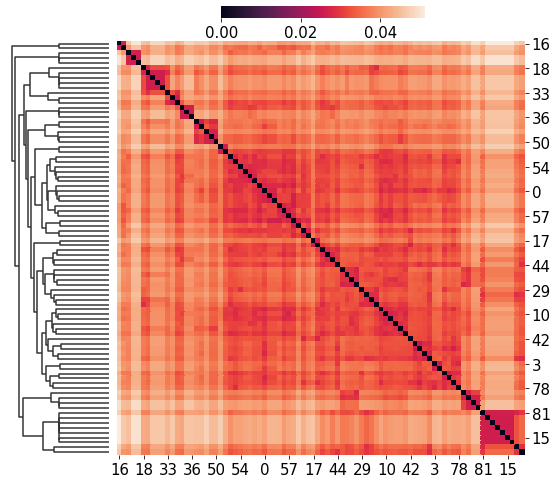

In [11]:
diff_avg = cf.get_average_distance_matrix(diffusion[1][0])
plotter.plot_clustermap(diff_avg, row_colors=None, method='complete', figsize=(8,8), linewidths=1.5, title='', name_to_save=None, dpi=200)

# Birth-death process

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Population- PARAMS: [1, 1, 3, 2]
Integration up to steady state...
[1, 1, 3, 2]


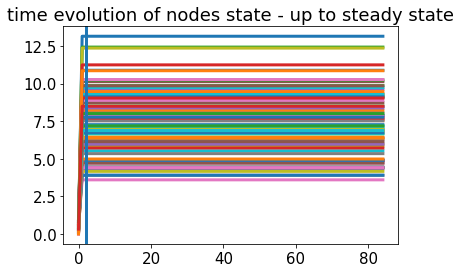

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population- PARAMS: [1, 1, 2, 1]
Integration up to steady state...
[1, 1, 2, 1]


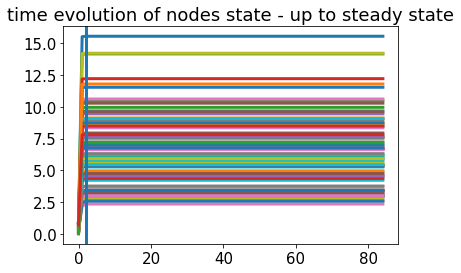

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population- PARAMS: [1, 1, 0.5, 0.2]
Integration up to steady state...
[1, 1, 0.5, 0.2]


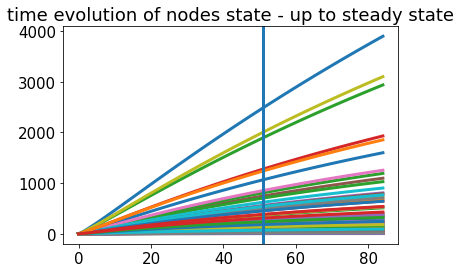

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

In [41]:
params = [[1, 1, 3, 2], [1, 1, 2, 1], [1, 1, 0.5, 0.2]]
dynamics = 'Population'

population = Simu_params(G, [], dynamics, params)

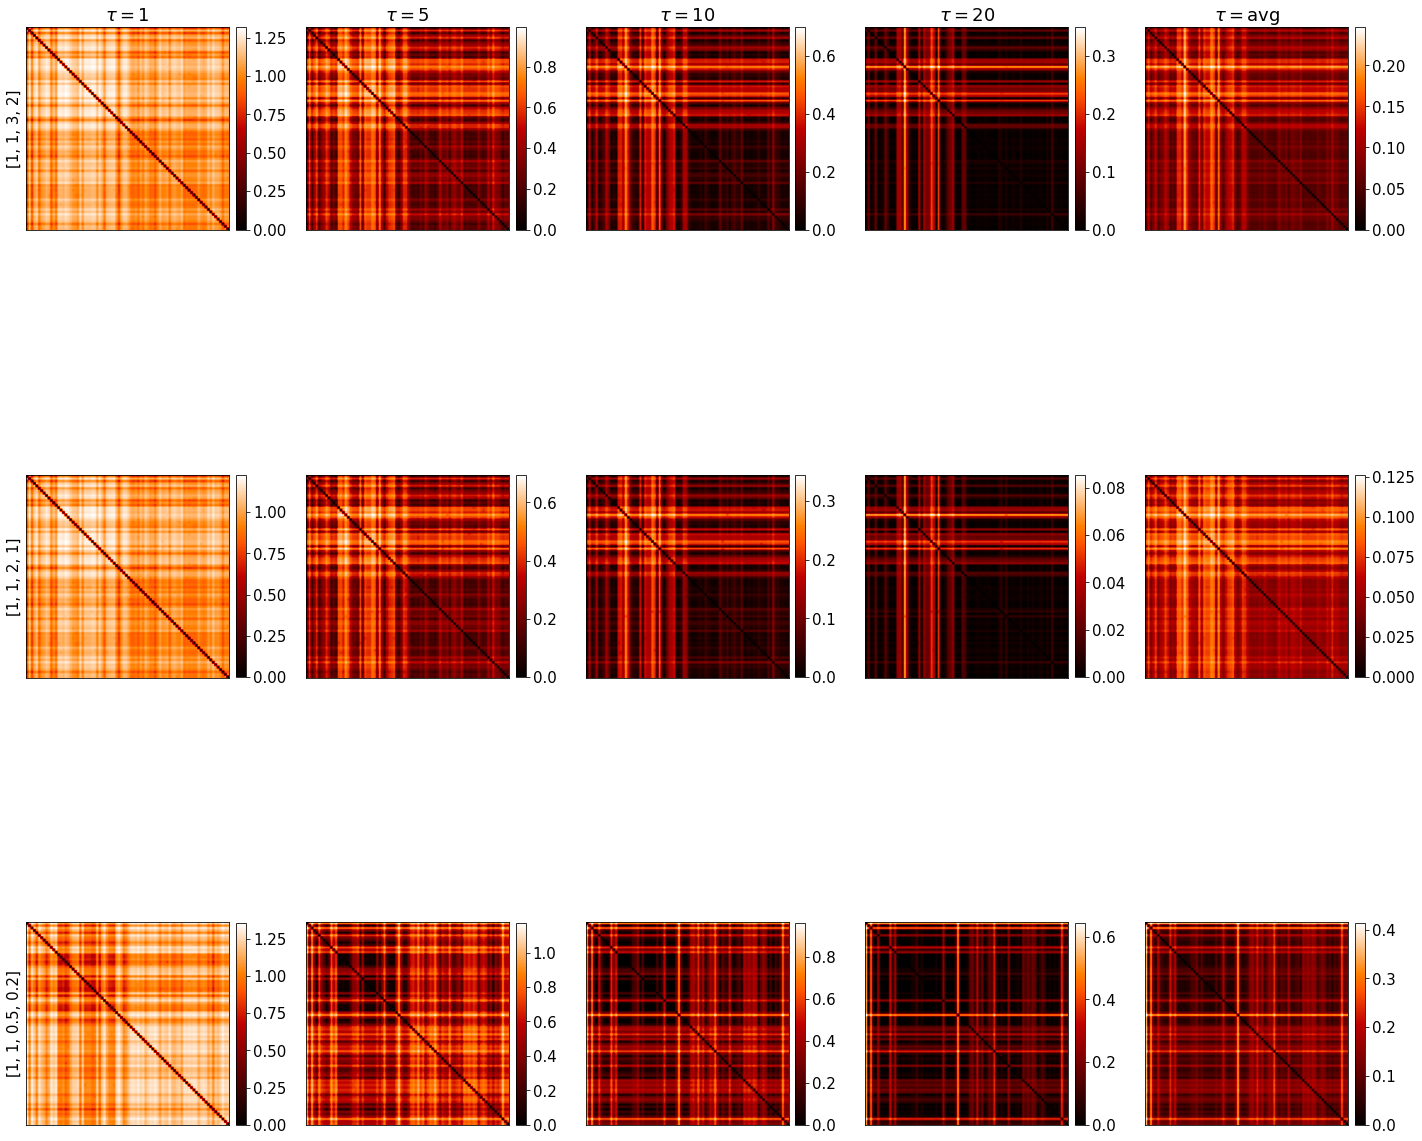

In [42]:
plotter.plot_dist_matrix_evol(population[1], params, hspace=-0.7)

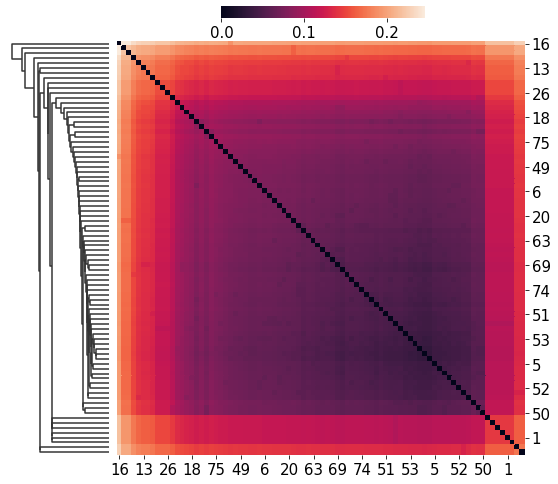

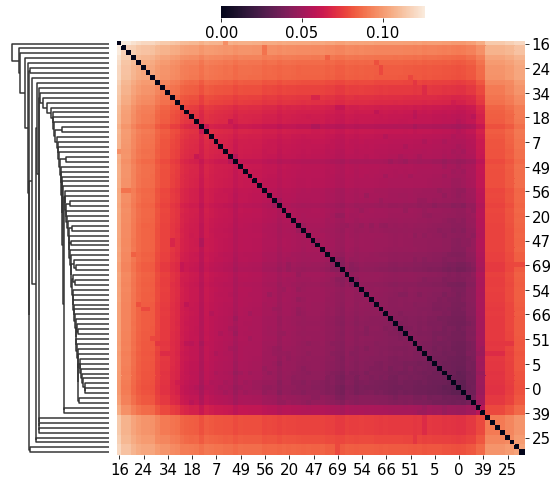

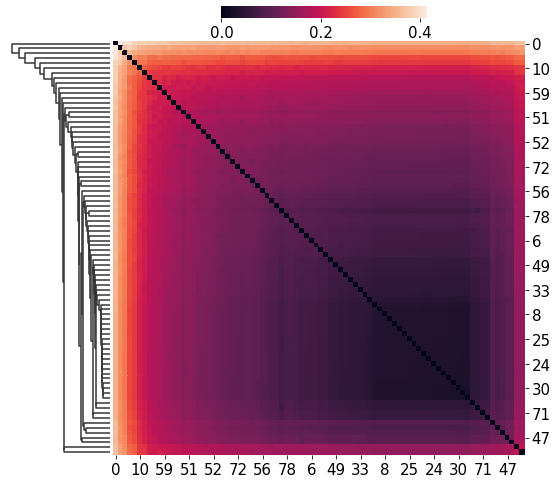

In [44]:
for i, param in enumerate(params):
    diff_avg = cf.get_average_distance_matrix(population[1][i])
    plotter.plot_clustermap(diff_avg, row_colors=None, method='complete', figsize=(8,8), linewidths=1.5, title='', name_to_save=None, dpi=200)

# Mutualistic

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic- PARAMS: [1, 1, 1]
Integration up to steady state...


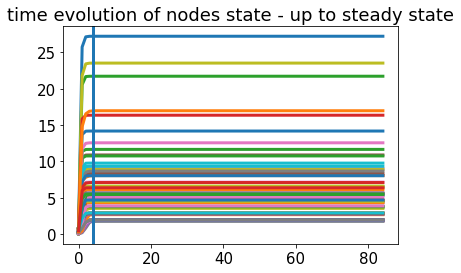

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Mutualistic- PARAMS: [1, 1, 2]
Integration up to steady state...


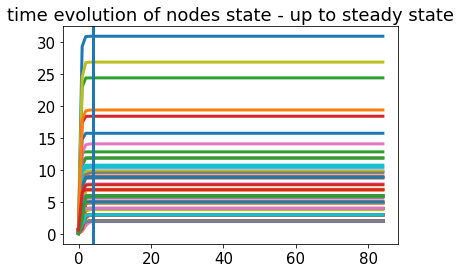

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Mutualistic- PARAMS: [1, 1, 0.5]
Integration up to steady state...


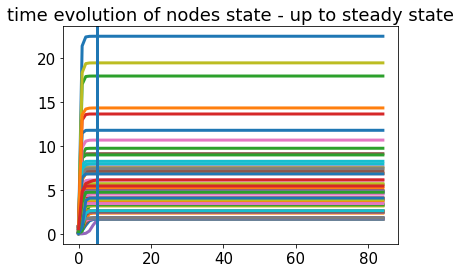

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

In [46]:
params = [[1, 1, 1], [1, 1, 2], [1, 1, 0.5]]
dynamics = 'Mutualistic'

mutualistic = Simu_params(G, [], dynamics, params)

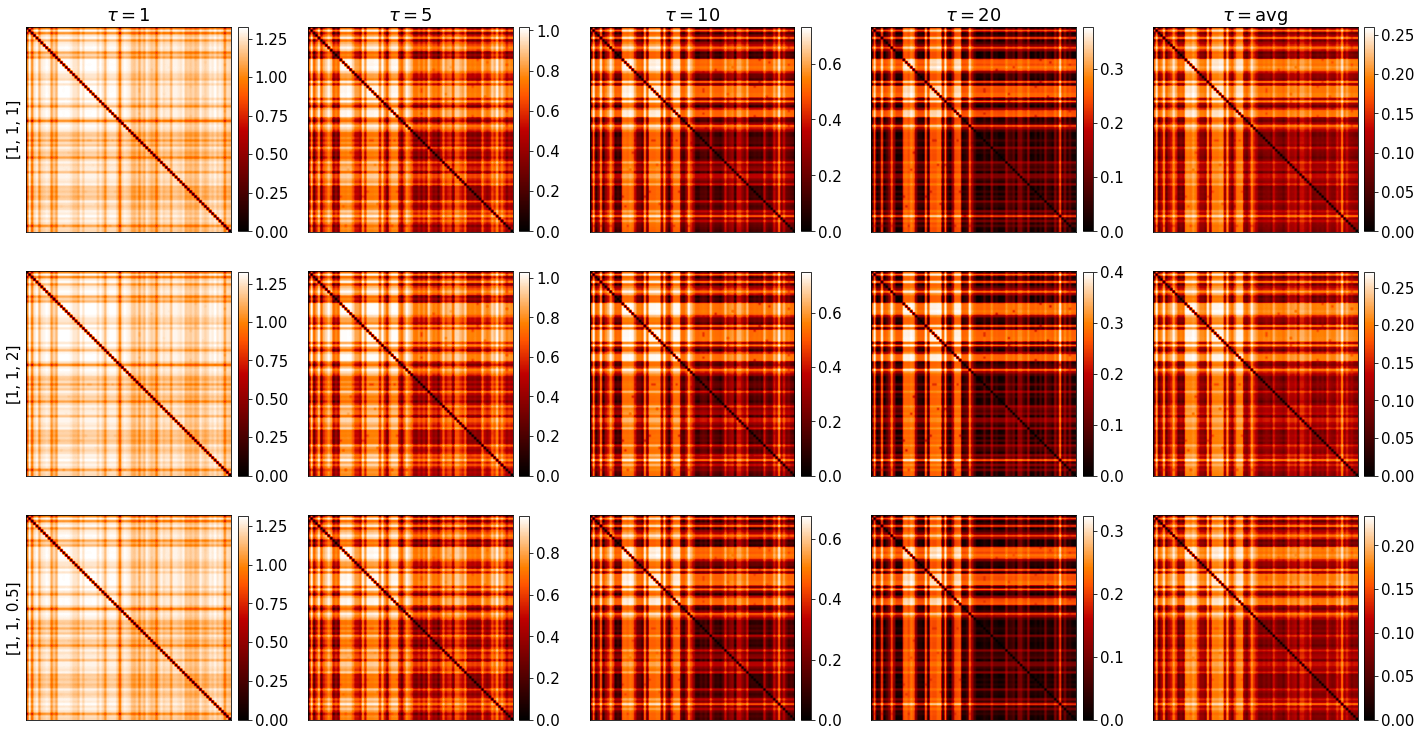

In [49]:
plotter.plot_dist_matrix_evol(mutualistic[1], params, hspace=-1.)

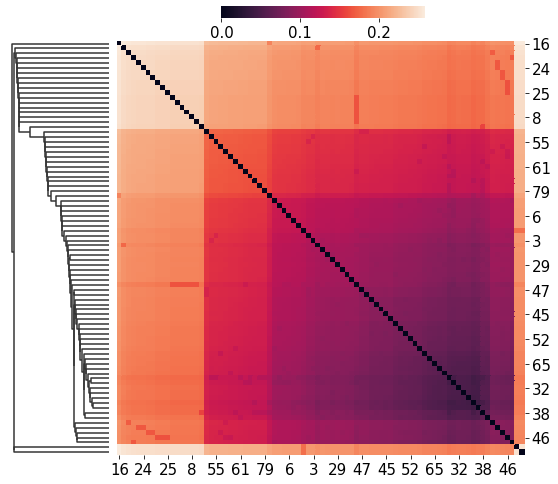

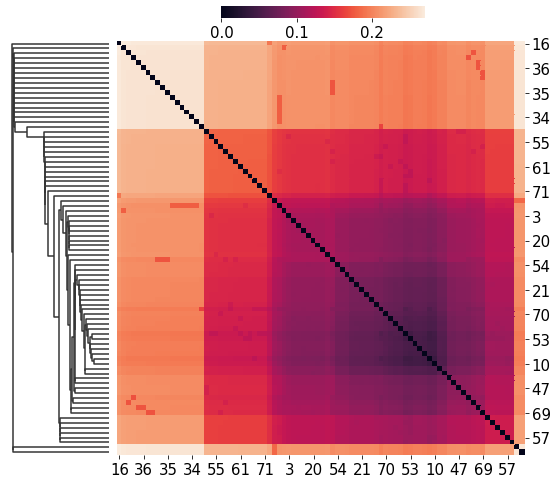

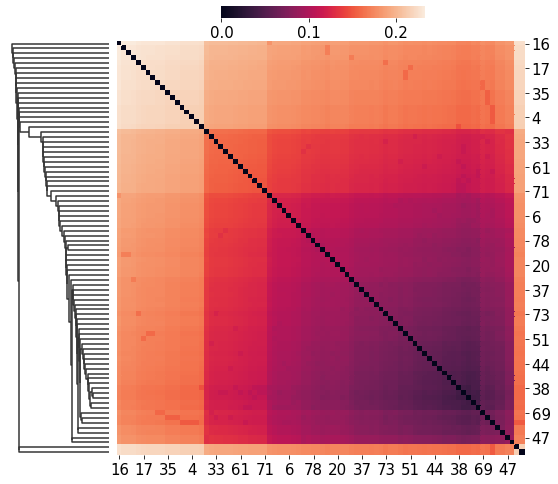

In [50]:
for i, param in enumerate(params):
    diff_avg = cf.get_average_distance_matrix(mutualistic[1][i])
    plotter.plot_clustermap(diff_avg, row_colors=None, method='complete', figsize=(8,8), linewidths=1.5, title='', name_to_save=None, dpi=200)

# Generalized Lotka-Volterra

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Biochemical- PARAMS: [0, 1, -0.12]
Integration up to steady state...


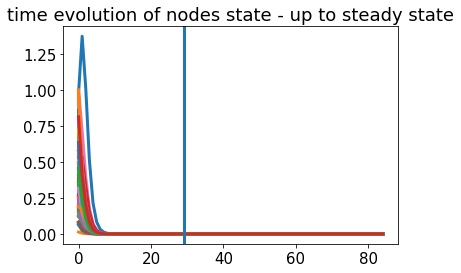

Evaluating jacobian distance...


  0%|          | 0/85 [00:00<?, ?it/s]

In [95]:
#params = [[0, 1, -0.2], [0.5, 1, -1], [1, 1, -1]]
params = [[0, 1, -0.12]]
dynamics = 'Biochemical'

lotka = Simu_params(G, [], dynamics, params)

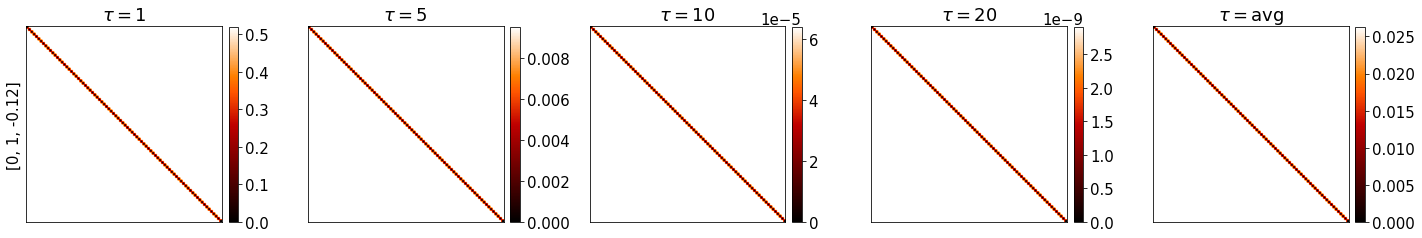

In [96]:
plotter.plot_dist_matrix_evol(lotka[1], params, hspace=-1.)

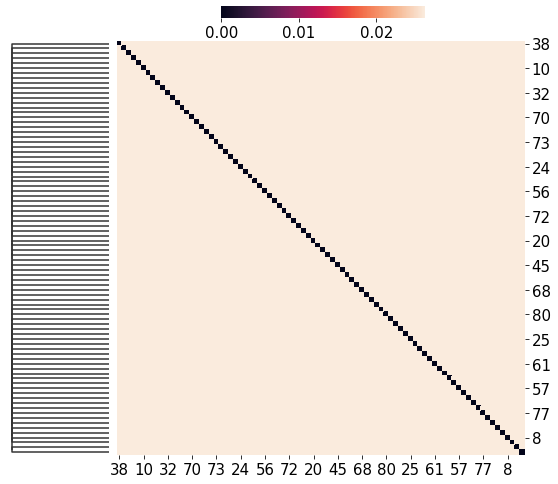

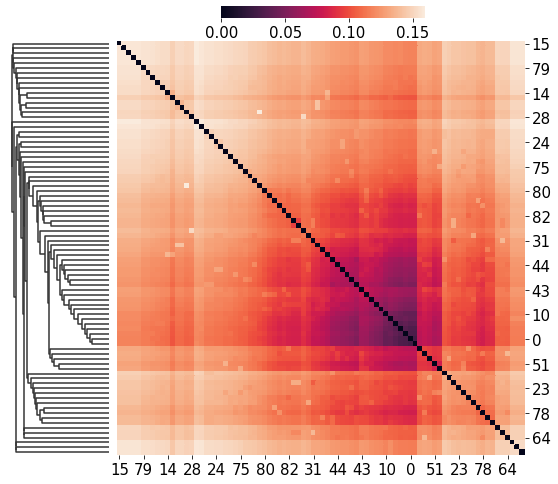

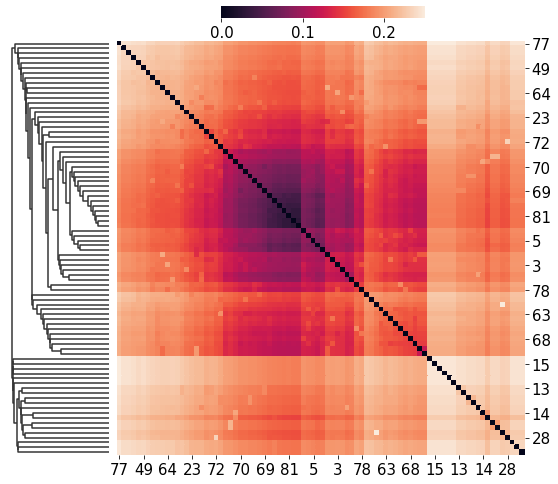

In [59]:
for i, param in enumerate(params):
    diff_avg = cf.get_average_distance_matrix(lotka[1][i])
    plotter.plot_clustermap(diff_avg, row_colors=None, method='complete', figsize=(8,8), linewidths=1.5, title='', name_to_save=None, dpi=200)